reference:https://github.com/puke3615/TextByRNN/blob/master/client.py

In [1]:
import tensorflow as tf
import numpy as np
import sys
import os

In [2]:
data='去年今日此门中，人面桃花相映红，人面不知何处去，桃花依旧笑春风。'
data

'去年今日此门中，人面桃花相映红，人面不知何处去，桃花依旧笑春风。'

In [3]:
# 参数设置
# 开始结束标识位
START,END='S','E'
# 模型参数保存路径
MODEL_PATH='data/'
# 最大迭代次数
MAX_ITERATOR=1000
# 是否输出数据信息
OUTPUT_DATA_INFO=True
# 每步预测输出
OUTPUT_EVERY_STEP=False
# 训练
TRAIN=True
# 预测
PREDICT=True

In [4]:
# 参数初始化方法定义
def init_weight(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.1))
def init_bias(shape):
    return tf.Variable(tf.constant(0.01,shape=shape))

 这里涉及一个知识点，关于截断分布的好处：
 
 http://sofasofa.io/forum_main_post.php?postid=1001430
 
 https://blog.csdn.net/u013713117/article/details/65446361
 
 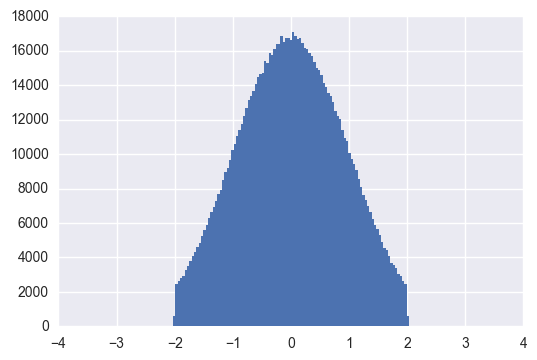
 
 在tf.truncated_normal中如果x的取值在区间（μ-2σ，μ+2σ）之外则重新进行选择。这样保证了生成的值都在均值附近。
 
 truncated_normal本质上也是生成正态分布的随机数，但是只保留两个标准差之内的点，在两个标准差之外的点就被舍去，然后重新抽样，直到达到你要求的个数为止。

In [5]:
# 模型定义
def model(x,batch_size):
    """
    """
    n_hidden=32
    depth=int(x.get_shape()[-1])
    W=init_weight([depth,n_hidden])
    b=init_bias([n_hidden])
    x=tf.matmul(x,W)+b
    
    x=tf.reshape(x,[batch_size,-1,n_hidden])
    cell=tf.contrib.rnn.BasicLSTMCell(n_hidden)
#     cell=tf.keras.layers.LSTMCell(n_hidden)

    
    initial_state=cell.zero_state(batch_size,tf.float32)
    outputs,last_state=tf.nn.dynamic_rnn(cell,x,initial_state=initial_state)
#     outputs,last_state=tf.keras.layers.RNN(cell,x,initial_state=initial_state)

#     keras.layers.RNN(cell)
    x=tf.reshape(outputs,[-1,n_hidden])
    
    W = init_weight([n_hidden, depth])
    b = init_bias([depth])
    x = tf.matmul(x, W) + b

    return x, initial_state, last_state

In [6]:
# 训练
def train(logits,labels,learning_rate=1e-2):
    cross_entropy=tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits)
    loss=tf.reduce_mean(cross_entropy)
    optimizer=tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return loss,optimizer

In [7]:
def print_info(array):
    if not OUTPUT_DATA_INFO:
        return
    r = ''
    if isinstance(array, dict):
        array = ['%s:%s ' % (k, v) for k, v in array.items()]
    for a in array:
        if isinstance(a, int):
            a = str(a) + ' '
        if isinstance(a, list):
            a = str(a) + ' '
        r += a
    print('[%s] %s' % (len(array), r))

In [8]:
def word2onehot(w, words2index, depth):
    index = words2index[w]
    return [1 if index == i else 0 for i in range(depth)]


In [9]:
data = START + data + END

words = list(set(data))
depth = len(words)
index2words = {i: word for i, word in enumerate(words)}
words2index = {v: k for k, v in index2words.items()}
print_info(words)
print_info(index2words)
print_info(words2index)


[27] 笑日去此不依。年今面风相红桃何，旧E门S人映处春花中知
[27] 0:笑 1:日 2:去 3:此 4:不 5:依 6:。 7:年 8:今 9:面 10:风 11:相 12:红 13:桃 14:何 15:， 16:旧 17:E 18:门 19:S 20:人 21:映 22:处 23:春 24:花 25:中 26:知 
[27] 笑:0 日:1 去:2 此:3 不:4 依:5 。:6 年:7 今:8 面:9 风:10 相:11 红:12 桃:13 何:14 ，:15 旧:16 E:17 门:18 S:19 人:20 映:21 处:22 春:23 花:24 中:25 知:26 


In [10]:
x_data = data
y_data = [x_data[i + 1] if i < len(x_data) - 1 else END for i in range(len(x_data))]
print_info(x_data)
print_info(y_data)
x_data = list(map(lambda w: word2onehot(w, words2index, depth), x_data))
y_data = list(map(lambda w: word2onehot(w, words2index, depth), y_data))


[34] S去年今日此门中，人面桃花相映红，人面不知何处去，桃花依旧笑春风。E
[34] 去年今日此门中，人面桃花相映红，人面不知何处去，桃花依旧笑春风。EE


In [11]:
y_data[0],len(y_data[0]) 
# 因为y_data的第一个字为去，在word2index中去的id为10，所以one中索引为11处为1，其余位置为0

([0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 27)

In [12]:
x = tf.placeholder(tf.float32, [None, depth])
y = tf.placeholder(tf.float32, [None, depth])

logits, initial_state, last_state = model(x, 1)
loss, train_step = train(logits, y)

if not TRAIN and not PREDICT:
    exit()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
checkpoint = tf.train.latest_checkpoint(MODEL_PATH)
if checkpoint:
    saver.restore(sess, checkpoint)
    print('Load last model params successfully.') 

if TRAIN:
    print('\nStart training...')
    for step in range(1, MAX_ITERATOR + 1):
        loss_value, _ = sess.run([loss, train_step], feed_dict={x: x_data, y: y_data})
        if step % 10 == 0 or step == MAX_ITERATOR:
            print('Step %s, Loss %s' % (step, loss_value)) 
        if step % 50 == 0 or step == MAX_ITERATOR:
            saver.save(sess, os.path.join(MODEL_PATH, 'model'))
if PREDICT:
    print('\nString predict...') 
    inputs = [START]
    inputs = list(map(lambda w: word2onehot(w, words2index, depth), inputs))
    predict = tf.nn.softmax(logits)
    outputs, last_state_value = sess.run([predict, last_state], feed_dict={x: inputs})
    print("\noutputs:",outputs)
    word = index2words[np.argmax(outputs)]
    result = ''
    while word != END:
        result += word
        if OUTPUT_EVERY_STEP:
            sys.stdout.write(word)
            sys.stdout.flush()
        outputs, last_state_value = sess.run(
            [predict, last_state], feed_dict={x: outputs, initial_state: last_state_value})
        word = index2words[np.argmax(outputs)]
    print(result) 

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_wi